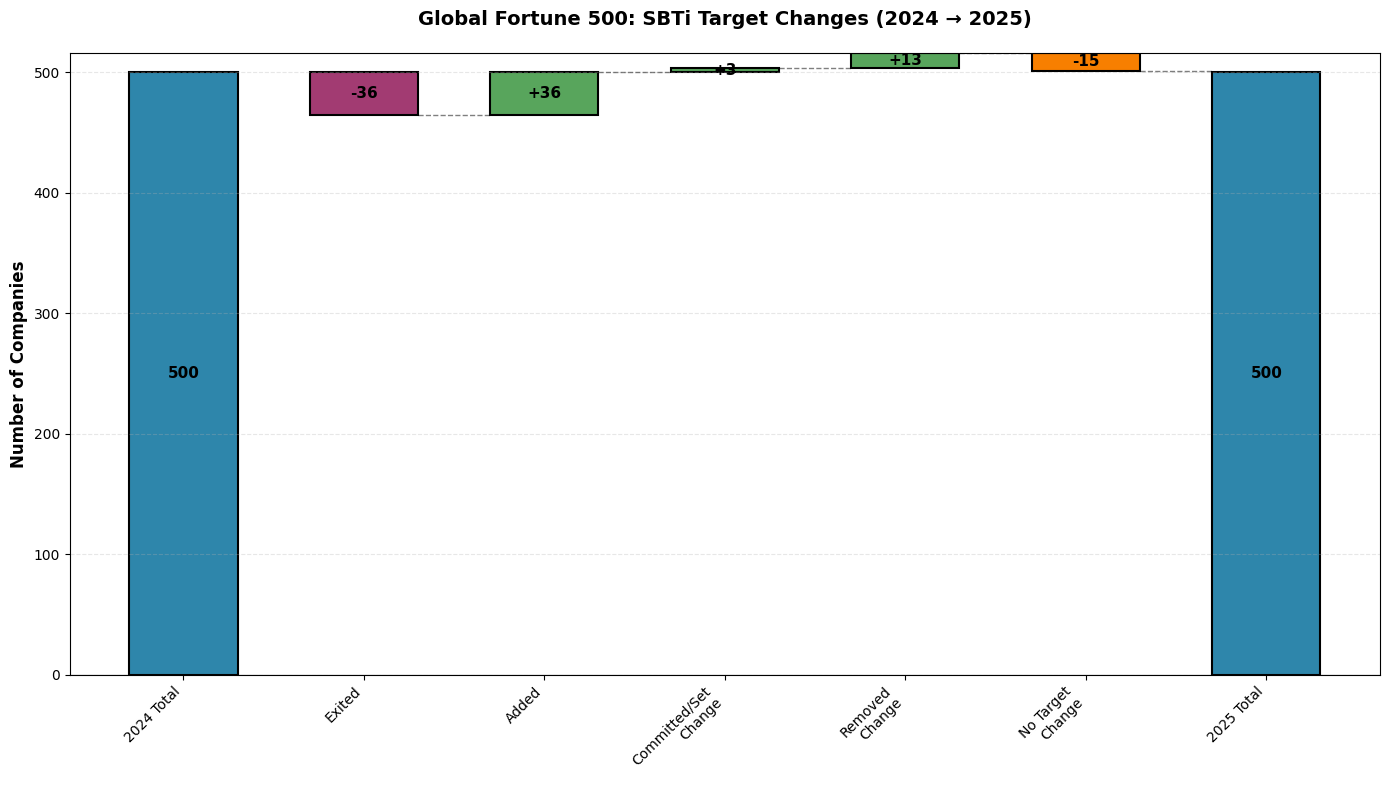

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
exited = len(companies_2024 - companies_2025)
added = len(companies_2025 - companies_2024)

# Map SBTi target status
def map_status(row, year):
    if year == 2024:
        status = str(row['Target status - NT']).strip()
    else:
        status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    
    if status in ['Targets Set', 'Targets set', 'Committed', 'T', 'C']:
        return 'Committed/Set'
    elif status in ['Removed', 'Commitment removed', 'R']:
        return 'Removed'
    else:
        return 'No Target'

# Count statuses
status_2024 = df_2024.apply(lambda row: map_status(row, 2024), axis=1).value_counts().to_dict()
status_2025 = df_2025.apply(lambda row: map_status(row, 2025), axis=1).value_counts().to_dict()

# Build waterfall data
categories = ['2024 Total', 'Exited', 'Added']
values = [500, -exited, added]
colors = ['#2E86AB', '#A23B72', '#58A55C']

for status in ['Committed/Set', 'Removed', 'No Target']:
    change = status_2025.get(status, 0) - status_2024.get(status, 0)
    if change != 0:
        categories.append(f'{status}\nChange')
        values.append(change)
        colors.append('#58A55C' if change > 0 else '#F77F00')

categories.append('2025 Total')
values.append(500)
colors.append('#2E86AB')

# Calculate cumulative positions
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot waterfall
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: SBTi Target Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:

pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 8.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [nbformat]5/6 [nbformat]a]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import plotly.graph_objects as go

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Map SBTi status
def map_status(row, year):
    if year == 2024:
        status = str(row['Target status - NT']).strip()
    else:
        status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    
    if status in ['Targets Set', 'Targets set', 'Committed', 'T', 'C']:
        return 'Committed/Set'
    elif status in ['Removed', 'Commitment removed', 'R']:
        return 'Removed'
    else:
        return 'No Target'

# Create status mappings for continuing companies
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Count transitions
transitions = {}
for company in continuing:
    old_status = map_status(df_2024_indexed.loc[company], 2024)
    new_status = map_status(df_2025_indexed.loc[company], 2025)
    key = (old_status, new_status)
    transitions[key] = transitions.get(key, 0) + 1

# Build Sankey
labels = ['2024: Committed/Set', '2024: Removed', '2024: No Target',
          '2025: Committed/Set', '2025: Removed', '2025: No Target']

source = []
target = []
value = []
colors = []

label_map = {'Committed/Set': 0, 'Removed': 1, 'No Target': 2}
color_map = {
    (0, 3): '#58A55C', (0, 4): '#F77F00', (0, 5): '#F77F00',
    (1, 3): '#58A55C', (1, 4): '#A23B72', (1, 5): '#A23B72',
    (2, 3): '#58A55C', (2, 4): '#F77F00', (2, 5): '#2E86AB'
}

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 3
    source.append(src)
    target.append(tgt)
    value.append(count)
    colors.append(color_map.get((src, tgt), '#CCCCCC'))

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        color=['#2E86AB', '#A23B72', '#666666', '#2E86AB', '#A23B72', '#666666']
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

fig.update_layout(
    title_text="SBTi Target Transitions (2024 → 2025)",
    font_size=12,
    height=600
)

fig.write_html('sankey_chart.html')

In [16]:
import pandas as pd

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Map SBTi status
def map_status(row, year):
    if year == 2024:
        status = str(row['Target status - NT']).strip()
    else:
        status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    
    if status in ['Targets Set', 'Targets set', 'Committed', 'T', 'C']:
        return 'Committed/Set'
    elif status in ['Removed', 'Commitment removed', 'R']:
        return 'Removed'
    else:
        return 'No Target'

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())

exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024
continuing = companies_2024 & companies_2025

# Track status changes
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

changes = []
for company in continuing:
    old_status = map_status(df_2024_indexed.loc[company], 2024)
    new_status = map_status(df_2025_indexed.loc[company], 2025)
    if old_status != new_status:
        changes.append({'Company': company, '2024': old_status, '2025': new_status})

# Create DataFrames
df_exited = pd.DataFrame({'Company': list(exited)})
df_added = pd.DataFrame({'Company': list(added)})
df_changes = pd.DataFrame(changes)

# Save to Excel
with pd.ExcelWriter('company_changes.xlsx') as writer:
    df_exited.to_excel(writer, sheet_name='Exited', index=False)
    df_added.to_excel(writer, sheet_name='Added', index=False)
    df_changes.to_excel(writer, sheet_name='Status Changes', index=False)

print(f"Exited companies: {len(exited)}")
print(f"Added companies: {len(added)}")
print(f"Companies with status changes: {len(changes)}")

Exited companies: 36
Added companies: 36
Companies with status changes: 39


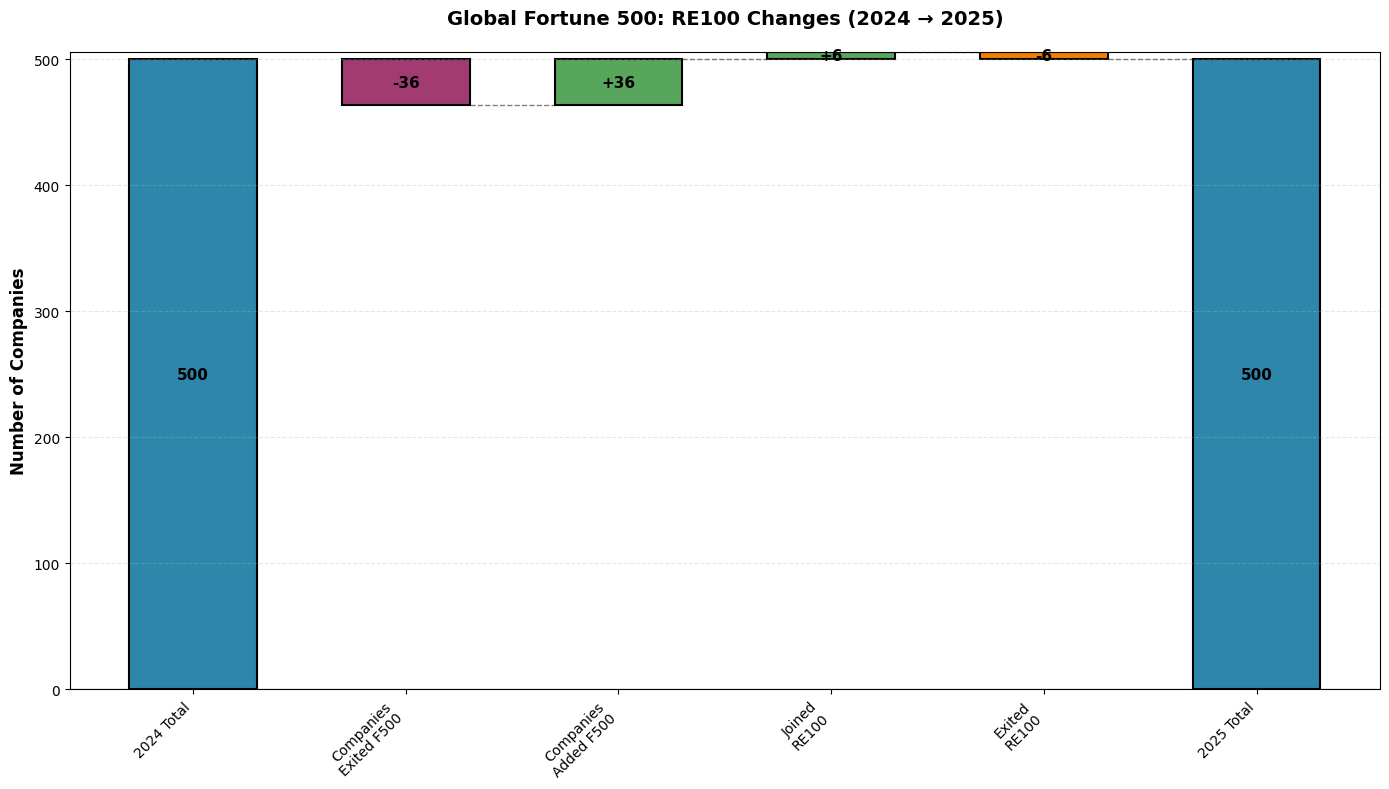

Joined RE100: 6
['Tongwei Group', 'Hon Hai Precision Industry', 'SK', 'Chevron', 'La Poste', 'Commonwealth Bank of Australia']

Exited RE100: 6
['Daiwa House Industry', 'Meta Platforms', 'Capital One Financial', 'Morgan Stanley', 'Siemens', 'Procter & Gamble']


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Map RE100 status
def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

# Track changes for continuing companies
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

joined = []
exited_re = []

for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    if old == 'Not in RE100' and new == 'In RE100':
        joined.append(company)
    elif old == 'In RE100' and new == 'Not in RE100':
        exited_re.append(company)

# Build waterfall
categories = ['2024 Total', 'Companies\nExited F500', 'Companies\nAdded F500', 
              'Joined\nRE100', 'Exited\nRE100', '2025 Total']
values = [500, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), 
          len(joined), -len(exited_re), 500]
colors = ['#2E86AB', '#A23B72', '#58A55C', '#58A55C', '#F77F00', '#2E86AB']

# Calculate cumulative
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: RE100 Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_re100.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Joined RE100: {len(joined)}")
print(joined)
print(f"\nExited RE100: {len(exited_re)}")
print(exited_re)